<h1><center> Understanding how Markovian models perform for autonomous driving(perception) purposes </center></h1>

### Paper: Goal Directed Pedestrian Prediction. Eike Rehder, ICCV15 
### Dataset: Daimler Dataset GCPR13 

> Dr. Renu M. Rameshan  
> Dr. Amit S. Unde  
> Aryan Garg  
  


In [1]:
# For all modules that produce a not-found / needs update error:
# In the notebook, before importing, write after
# Replacing angular brackets with module name:
# ! pip install <package-name-as-per-package's-documentation>

import cv2 
from PIL import Image
import imutils
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import sys
import math
import scipy.stats as stats
from scipy import signal


print(f"[+]Loading essential packages...")
print(f"[+]Loaded OpenCV version {cv2.__version__} @ {time.asctime(time.localtime(time.time()))}\n")

[+]Loading essential packages...
[+]Loaded OpenCV version 4.5.2 @ Tue Oct  5 12:13:10 2021



In [2]:
class preProcessData:
    
    def readData(self, trainDataP):
        try:
            self.dirs = [f for f in listdir(trainDataP)]
            for directory in self.dirs:
                newPath = self.trainDataPath + directory + "\\RectGrabber\\"
                files = [f for f in listdir(newPath) if isfile(join(newPath, f))]
                self.allTrainingData[directory] = files
            #print(self.allTrainingData)
            return True
        
        except Exception as err:
            print(err)
            print("Couldn't read data. Check file paths and file health!")
            return False
        
    
    
    def showFrames(self, windowName, imglst):
        if len(windowName) != len(imglst):
            print(f"windowName list len: {len(windowName)} not equal to imglst len: {len(imglst)}")
            return False 
        
        for i in range(len(windowName)):
            cv2.imshow(f"{windowName[i]}", imglst[i])
        
        k = cv2.waitKey(0)
        if k is not None:
            cv2.destroyAllWindows()
        
        return True
        
    def showSampleImages(self, folderName = "2012-06-05_165931"):
        ### TODO: Decrease Image size
        print("[+] Logging sample images' details\n---------------------")
        for i in range(1,10,2): 
            img_left = self.allTrainingData[folderName][i-1]
            img_right = self.allTrainingData[folderName][i]

            try:
                imgL = cv2.imread(self.trainDataPath + folderName + "\\RectGrabber\\" + img_left)
                imgR = cv2.imread(self.trainDataPath + folderName + "\\RectGrabber\\" + img_right)
                
                imgL = cv2.resize(imgL, (600,450))
                imgR = cv2.resize(imgR, (600,450))
                print(f"{(i//2) + 1}. Image names: {img_left} & {img_right}\n\t\tShape-L: {imgL.shape}     Shape-R: {imgR.shape}\n")
                
                if not self.showFrames(["Left frame", "Right frame"], [imgL, imgR]):
                    print(f"Couldn't show sample images from showSampleImages function")
            
            except Exception as err:
                print(err)
                if imgL is None:
                    print(f"[!]Couldn't load L-image: {img_left}")
                if imgR is None:
                    print(f"[!]Couldn't load R-image: {img_right}")
                continue
                
        print("---------------------\n[+] Finished viewing initial samples.")

    
    
    def frameFromLR(self):
        ### TODO: Will have to refer to the 14th paper later
        ### For now standard
        pass
    
    
    def removeNoise(self):
        ### TODO: Future optimization
        pass
    
    
    def createVideo(self, folderNum):
        try:
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
            video = cv2.VideoWriter('out_video.avi', fourcc, 30.0, self.allTrainingData[folderNum][0].shape)
        
            for imgL, imgR in self.allTrainingData[folderNum][:121]:
                video.write(imgL)

            video.release()
            cv2.destroyAllWindows()
            print(f"[+]Video out_video.avi released")
            
        except Exception as err:
            print(err)
            print(f"Possible fixes:\n1. See if DIVX is compatible with your machine\n2. Use a media player that supports .avi\n\
                    3. Match the shape of frames with the video")

    def detectPedestriansAnnotations(self, dirName, imageList):
        '''
            
            Brief: Making bounding boxes using the annotations provided in dataset
            
            Need to use SQL queries here to extract info!!! (.db files are present)
            
        '''
        print("\nCreating Bounding Boxes...")
        print(f"\nDRAWING FOR {dirName}")
        path_ = 'C:\\Users\\HP\\Desktop\Research\\Trajectory_Markov_Research\\Implementations\\Dataset_Dailmer\\TrainingData_Annotations\\'
        path_ += str(dirName)+"\\LabelData\\"
        # creating file path
        dbfile = path_ + "meas.db"
        
        toRet = []
        with open(dbfile) as f:
            
            rd = f.readlines()
            # Text formatting params:
            font                   = cv2.FONT_HERSHEY_COMPLEX_SMALL
            fontScale              = 0.7
            fontColor              = (255, 255, 255)
            lineType               = 2
            for i in range(len(rd)):
                imgName = ""
                box_cos = ""
                
                if "img" in rd[i]:
                    imgName = rd[i][:-1]
                    
                    if i+6 < len(rd):
                        box_cos = rd[i+6].split()
                        if len(box_cos) != 4:
                            continue
                    else:
                        continue
                    
                    imgName = "imgrect_"+imgName[4:] 
                    #print(f"{imgName}:{box_cos}")
                    
                    img = cv2.imread( "C:\\Users\\HP\\Desktop\\Research\\Trajectory_Markov_Research\\Implementations\Dataset_Dailmer\\Data\\TrainingData\\" 
                                     + dirName + "\\RectGrabber\\" + imgName )
                    
                    if img is None:
                        print("[-]Image could not load!")
                        continue
                
                    
                    box_cos = [int(e) for e in box_cos]
                    
                    if dirName not in self.detectedDataBox:
                        self.detectedDataBox[dirName] = []
                        
                    self.detectedDataBox[dirName].append(box_cos) 
                    x,y,a,b = box_cos # Top left: (x,y) ; Bottom Right: (a,b)
                    cv2.rectangle(img, (x, y), (a,b), (0, 255, 0), 2)
                    #cv2.putText(img,'Person', (int(x),int(y)), font, fontScale,fontColor,lineType)
                    
                    #cv2.imshow("Bounding Box from Annotations", img)
                    #cv2.waitKey(0)
                    
                    toRet.append(img)
            
            f.close()
            return toRet

    
    def detectPedestriansHOG(self, dirName, imageList): 
        '''
            Brief: 
                    Standard Histogram Oriented Gradients Object Detection provided by openCV. 
                    (Dalal & Triggs)
            |
            Param:
                    frame -> For which pedestrian detection must be done
                    
            Returns:
                    Frame with a green bounding box around pedestrians
        '''
        
        toRet = []             # This list will become the object detected data list's part
        
        # Text formatting params:
        font                   = cv2.FONT_HERSHEY_COMPLEX_SMALL
        fontScale              = 0.7
        fontColor              = (255, 255, 255)
        lineType               = 2
        
        # Initialize standard HOG people detector
        hog = cv2.HOGDescriptor()
        hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
        
        for imgName in imageList:
            img = cv2.imread( self.trainDataPath + dirName + "\\RectGrabber\\" + imgName )
            
            if img is None:
                continue
                
            img = cv2.resize(img, (600, 450))
            (rects, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1)
            
            for (x, y, w, h) in rects:
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img,'Person', (x,y), font, fontScale,fontColor,lineType)
            
            toRet.append(img)
                
            #if not self.showFrames(["Bounding Box"], [img]):
             #   print(f"Couldn't show pedestrian detected image: {img}")
            
        
        return toRet
           
    
    def __init__(self):
        ### Change filepath according to your machine config
        self.trainDataPath = "C:\\Users\\HP\\Desktop\\Research\\Trajectory_Markov_Research\\Implementations\Dataset_Dailmer\\Data\\TrainingData\\"
        self.dirs = []
        self.allTrainingData = dict()
        if self.readData(self.trainDataPath):
            #self.showSampleImages()
            self.detectedData = {}
            self.detectedDataBox = {} # Contains TL cos and BR cos of a frame (directory-wise)
            doOneDir = True
            for key in self.allTrainingData:
                if doOneDir:
                    self.detectedData[key] = self.detectPedestriansAnnotations(key, self.allTrainingData[key])
                    cv2.destroyAllWindows()
                    break
                else:
                    self.detectedData[key] = self.detectPedestriansAnnotations(key, self.allTrainingData[key])
                    cv2.destroyAllWindows()

In [19]:
class model:
    '''
    Brief:
        Goal Directed Pedestrian Prediction 
        (A markovian approach for pedestrian trajectory prediction)
        
    Receives:
        Pre-processed and pedestrain detected data from preProcessData class
        
    Returns:
        Predicted Trajectory of each pedestrian in scene
                
    '''
    
    # State Transition stuff ahead:
    def compute_X(self, dirName = '2012-04-02_115542', numFramesToObserve = 90):
        # COMPUTING ONLY FOR THE TL PIXEL OF RECTANGLE 
        for i in range(1, numFramesToObserve):
            x1, y1, a1, b1 = self.dfBox[dirName][i-1]
            x2, y2, a2, b2 = self.dfBox[dirName][i]
            vx = (x2 - x1) * self.fps    # TODO: Use more valid points to compute an average velocity
            vy = (y2 - y1) * self.fps
            #print(f"*** Frames {i-1} and {i} ***\nvx: {vx} px/sec\nvy: {vy} px/sec")
            psi = 0
            if (x2-x1) != 0:
                psi = math.atan2(  (y2-y1) , (x2-x1) ) # Slope 
            #print(f"phi_t: {math.degrees(psi)} degrees\n")
            self.uni.append([vx, vy, 0])
            self.X.append([x1 + vx/self.fps, y1 + vy/self.fps, 0 + psi]) # Xt = Xt-1 + u(v_t, psi_t) 
        self.eq3_dist_X()
    
    def eq3_dist_X(self):
        '''
            phi_t = p( X_t | X_t-1 )
            p(Xt|Xt−1) = p(Xt−1) ⊗ p(u(vt, ψt))
        '''
        self.distX = np.zeros(shape=(640, 1176))
        n = len(self.X)
        
        for i in range(n):
            self.distX[int(self.X[i][1])][int(self.X[i][0])] += 1 / n
        
        #print(self.distX)
        #print(self.distUni)
        
        #plt.subplot(1,2,1)
        #plt.imshow(self.distX)
        #plt.subplot(1,2,2)
        #plt.imshow(self.distUni)
        #plt.show()
        # Convolve the two grid distributions
        #self.Xt_given_Xt_1 = conv_pmf = signal.fftconvolve(self.distX, self.distUni, 'same')
        
        #print(f"P(Xt|Xt-1) = P(Xt-1) * p(u(vt,psit)) =\n{self.Xt_given_Xt_1}")
        
        #for i in range(640):
        #    for j in range(1176):           
        #        if self.Xt_given_Xt_1[i][j] >= 1:
        #            print(f"cell({i},{j})'s p(Xt|Xt-1) = {self.Xt_given_Xt_1[i][j]}\nNOT POSSIBLE! RE-CHECK CONVOLUTION")
                
        #plt.imshow(disp)
        #plt.show()
        self.eq4()
    
    def discretization_2_grid(self, p, x, y):
        '''
            Consider 1x1 cells -> assign probability(from incremental distribution) to each cell
            At the end: A (the convolution filter mask) is obtained 
        '''
        self.A[int(y)][int(x)] = p
        
    
    
    def mean_var(self, samples):
        mean = sum(samples) / len(samples)
        var = 0
        for e in samples:
            var += (e - mean)**2
        var /= len(samples)-1 
        return mean, var
    
    
    def vonMises(self, samples):
        R = 0                      # 1/N * Summation{e^i.\theta}
        for i in range(len(samples)):
            R += math.cos((i+1)*samples[i]) + 1j*math.sin((i+1)*samples[i])
        
        Rbar = np.abs(R)/len(samples)
        kappa_v = (2*Rbar - (Rbar**3)) / (1 - (Rbar**2)) # This is an approximation for fast computation only!
        
        # TODO: Find closer approximation from Bessel function or Ap^-1
        return Rbar, kappa_v
    
    
    def eq4(self):
        '''
        Model the incremental distribution:
            This is p(u(v, psi)) effectively...
            
            p(∆x, ∆y, ∆ψ) ∝  exp(−(∆x−∆tv cos(ψ))^2/2σ_v^2)
                            .exp(−(∆y−∆tv sin(ψ))^2/2σ_v^2)
                            .exp(κ∆ψ cos(∆ψ))
                            .exp(κv cos(∠(∆y, ∆x) − ψ))
                            
        Then call self.discretization_2_grid() to get A (the convolution filter mask)
        Then call eq5 to get phi_t using A and phi_t-1
        
        v   -> Normal Dist.             
        psi -> circular Normal Dist.
        '''
        # p[x][y][psi] = model it!!!
        vx_mu, vx_var = self.mean_var([e[0] for e in self.uni])
        vy_mu, vy_var = self.mean_var([e[1] for e in self.uni])
        psi_mu, psi_kappa = self.vonMises([e[2] for e in self.X])
        
        kappa_nonAligned = 1   # TODO: Figure out if this can be found from the data or is a free parameter
        
        # TODO: Now find p(del_x, del_y, del_psi)
        x,y,z = self.X[-1] # Get filter: A, from last observed position-orientation tuple
        # Keeping to a region of -20 to +20
        for i in range(-50, 51):
            for j in range(-50, 51):
                xprev = x + i
                yprev = y + j
                if i != 0:
                    zprev = z - math.atan2((y - yprev),(x - xprev))
                else:
                    if y - yprev < 0:
                        zprev = z + math.pi/2
                    else:
                        zprev = z - math.pi/2
        
                # Constant of proportionality  
                from scipy.special import kn
                k = 8*(math.pi**3)*math.sqrt(vx_var)*math.sqrt(vy_var)*kn(0, psi_kappa)*kn(0, kappa_nonAligned) 
                
                P_del_xyz = 1/k
                P_del_xyz *= math.exp(-(((x-xprev) - vx_mu/self.fps)**2)/(2*vx_var)) 
                #print(self.P_delDist, math.exp(-(((x-xprev) - vx_mu/self.fps)**2)/(2*vx_var)) )
                P_del_xyz *= math.exp(-(((y-yprev) - vy_mu/self.fps)**2)/(2*vy_var)) 
                #print(self.P_delDist,  math.exp(-(((y-yprev) - vy_mu/self.fps)**2)/(2*vy_var)))
                
                P_del_xyz *= math.exp(psi_kappa * math.cos(z - zprev))
                #print(self.P_delDist, psi_kappa )
                
                angle = 0 # goes in non-alaigned term
                if  x-xprev == 0:
                    angle = math.pi/2 # arctan(infinity) is pi/2
                    if y - yprev < 0:
                        angle *= -1 # arctan(-inf) is -pi/2
                else:    
                    angle = math.atan2((y-yprev),(x-xprev))
                
                P_del_xyz *= math.exp( kappa_nonAligned * math.cos(angle - z) )
                #print(P_del_xyz,  math.exp( kappa_nonAligned * math.cos(angle - z)))
                self.discretization_2_grid(P_del_xyz, x+i, y+j)                      
        print(f"Filter A computed!")
        
   
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        
        plt.figure(figsize = (16,12))
        plt.title("Filter A")
        plt.imshow(self.A)
        plt.show()
        self.eq5()
        
    
    def eq5(self):
        '''
            Φt ∝ A ⊗ Φt−1
            where Φt = P( Xt | Xt-1 ) {contained in self.Xt_given_Xt_1} 
            Convolve here
            
            Do something like:
            #self.Xt_given_Xt_1 = conv_pmf = signal.fftconvolve(self.distX, self.A, 'same')
        '''
        self.Xt_given_Xt_1 = signal.fftconvolve(self.distX, self.A, 'same')
        self.get_XTs()
        
    
    def get_XTs(self):
        pass
    
    
    def eq6(self):
        '''
            Invert distribution in 4 to get (B)           [A^(-1)]
            *** For backward prediction steps from XT ***
        '''
        pass
    
    
    def eq7(self):
        '''
            Carry out forward and backward steps to get each p(Xt | X0, XT) acc. to:
            p(Xt|X0, XT ) ∝ Φ+t Φ−t
        '''
        pass
    
    
    # Location Prior stuff ahead
    def eq8(self):
        '''
            Forward step:
            Φ+t ∝ p(Xt|Θt)(A ⊗ Φ+t−1)
            
            where Θt is the online map
                  p(X|θi) is the location prior (call eq10 here)
        '''
        pass
    
    
    def eq9(self):
        '''
            Backward step:
            Φ−t−1 ∝ p(Xt|Θt)(A^(−1) ⊗ Φ−t)
            
            call eq10 from here
        '''
        pass
    
    
    def eq10(self):
        '''
            Computes Location prior: p(X|θi) acc to:
            
            Single Layer Perceptron: 
            p(X|θi) = 1 / 1 + exp (−a^T . θ_i)
            
            where a^T represents weighting params for different features. 
        '''
        pass
    
    
    def eq11(self):
        '''
            Path Distribution: 
            p(XM|X0, XT , Θt) = 1 −PI[(M) <-- (t˜=0)](1 − p(Xt˜|X0, XT , Θt))
        '''
        pass
    
    
    def eq12(self):
        '''
            Cost function to get best weighting params, i.e, a:
            J(a) = −Summation[ ζi ∈ Xj ] Summation[ Xj ∈ ζi ] log(p(X = Xj |X0, XT , Θt))
        '''
        pass
    
    # Goal Distribution XT Estimation ahead
    def eq13(self):
        '''
            p(Xt) ::= estimated distribution for the pedestrian’s state at time = t. 
            p(X−t|X0, XT , Θt) ::= the distribution of that state obtained from prediction at t-1. 
        
            [!] After Assumption: Independence
            Can obtain:
        
                pX− (X−t|X0, XT , Θt) ∝ pX− (X0, XT , Θt|X−t)p(X−t)
        
        '''
        pass
    
    
    def eq14(self):
        '''
            p(XT ) ∝ Integral of pX− (X0, XT , Θt|Xt).p(Xt).dX
            
            [+] Evaluated for the individual particles and the result is used for reweighting
            Next TODO: Unlikely particles are discarded and randomly resampled at other locations.
        '''
        pass
    
    
    def __init__(self, bb_Images, bb_cos):
        self.df = bb_Images
        self.dfBox = bb_cos
        self.grid = np.zeros(shape=(640, 1176)) # Grid
        self.fps = 30                          # fps
        self.X = []                            # Contains last t positions & orientations: (x_t, y_t, psi_t)
        self.distX = None                      # Contains X's distribution on grid
        self.uni = []                          # Contains unicycle vector of motion: u(vt, psi_t) 
        self.distUni = None                    # Contains uni's distribution on grid as per X's co-ordinates
        self.Xt_given_Xt_1 = None              # Contains distribution: P(X_t | X_t-1)
        self.px0 = 0
        self.XT = None                         # Latent Variable: Gaussian Mixture Model + Particle Filter
        self.A = np.zeros(shape=(640, 1176))
        for key in self.df:
            self.compute_X(key)  # Watch 1 sec to estimate X
        
            
        

In [20]:
class analytics:
    '''
    Brief:
        Analyzes predicted trajectories against ground truth.
        
    Receives:
        Predicted trajectories from model class
        
    Displays:
        Accuracy and evaluation metrics. And other visual-aids for analysis of the model
                
    '''
    pass

In [21]:
df = preProcessData()                       # Remove noise, use paper 14, Detect pedestrians and then pass to model
#print(df.detectedData)


Creating Bounding Boxes...

DRAWING FOR 2012-04-02_115542


Filter A computed!


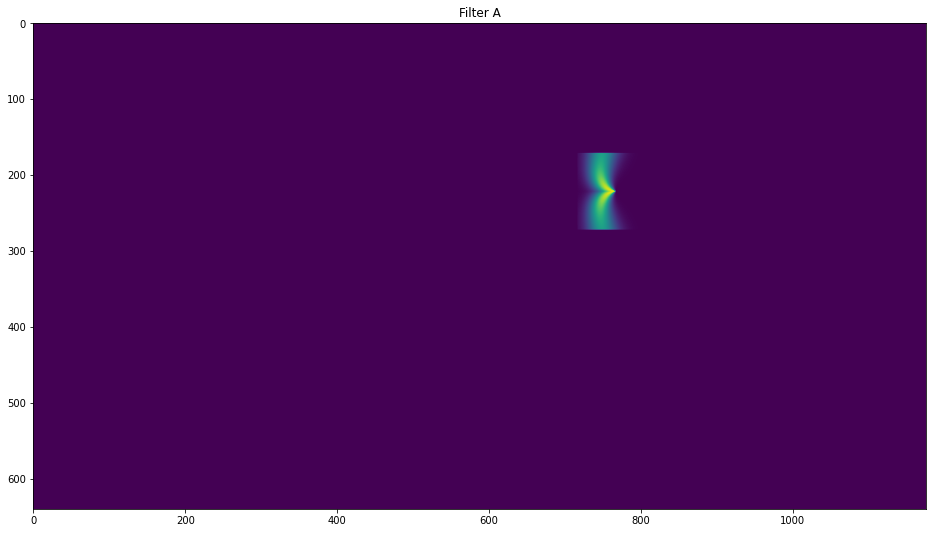

In [22]:
predicted_df = model(df.detectedData, df.detectedDataBox)

## Pointers/Terminolgy I'm using:

#### Grid distribution => probability distribution of grid / a probability value is assigned to cell (x,y)